## Fly Walking Navigation Scenario

This notebook runs a walking scenario in the flygym environment and applies the neural direction estimation model to the observed heading and body-centric translational direction of the fly

Videos of the fly walking and the modelled neuron population activity evolution over the trial are written to the `outputs/` folder

The walking controller is derived from the week 3 exercise code for the COBAR course.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from gymnasium import spaces
from gymnasium.utils.env_checker import check_env

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork


_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

In [2]:
class TurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        return obs, info

    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

In [3]:
run_time = 1
timestep = 1e-4
contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",
    render_playspeed=0.1,
    enable_adhesion=True,
    draw_adhesion=True,
)

nmf = TurningNMF(
    sim_params=sim_params,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0, 0, 0.2),
)

In [4]:
check_env(nmf)

c:\Users\camer\anaconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:247: UserWarning: WARN: For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.
  logger.warn(
c:\Users\camer\anaconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:225: UserWarning: WARN: A Box observation space minimum value is -infinity. This is probably too low.
  logger.warn(
c:\Users\camer\anaconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:229: UserWarning: WARN: A Box observation space maximum value is -infinity. This is probably too high.
  logger.warn(
c:\Users\camer\anaconda3\envs\flygym\Lib\site-packages\gymnasium\utils\env_checker.py:321: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make
  logger.warn(


In [5]:
class TurningNMF1D(TurningNMF):
    def __init__(self, r=1, **kwargs):
        super().__init__(**kwargs)
        self.action_space = spaces.Box(-1, 1, shape=(1,))

    def step(self, action):
        angle = (action + 1) * np.pi / 4
        action = 1 * np.array([np.cos(angle), np.sin(angle)])
        return super().step(action)


nmf1d = TurningNMF1D(
    sim_params=sim_params,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0, 0, 0.2),
)

check_env(nmf1d)

Text(0, 0.5, 'Action')

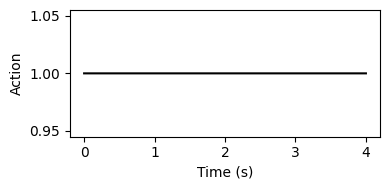

In [6]:
from scipy.signal import sawtooth

run_time = 4
n_steps = int(run_time / nmf.sim_params.timestep)
actions = sawtooth(np.linspace(0, 4 * np.pi, n_steps), 0.5)*2 # slalom
actions = np.ones(actions.shape) # spinning on itself

fig, ax = plt.subplots(1, 1, figsize=(4, 2), tight_layout=True)
ax.plot(np.arange(n_steps) * nmf.sim_params.timestep, actions, c="k")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Action")

In [7]:
obs_hist = []
obs, info = nmf1d.reset(seed=0)

for i in trange(n_steps):
    obs = nmf1d.step(actions[i])[0]
    obs_hist.append(obs)
    nmf1d.render()

nmf1d.save_video("./outputs/turning1d.mp4")
# Video("./outputs/turning1d.mp4")

100%|██████████| 40000/40000 [02:26<00:00, 272.80it/s]


In [8]:
trajectory = np.array([obs["fly"][0, :2] for obs in obs_hist])
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(trajectory[:, 0], trajectory[:, 1], color="k")
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")

Text(0, 0.5, 'y (mm)')

## Run the navigational neural model on the logged trajectory

In [9]:
### get the relevant quantities from the run recording
from scipy import signal

world_dir_log = np.array([obs["fly"][1, :2] for obs in obs_hist]) # fly velocity vector over time in the world frame
orientation_log = np.array([obs['fly_orientation'] for obs in obs_hist]) # fly orientation unit vector over time in the world frame

# downsample and convert to navigator-compatible inputs
sample_rate = 100 # Hz
render_playspeed = 0.1 # this is set for the render above
timestep = nmf.sim_params.timestep # 1e-4 normally

sample_ratio = (1/sample_rate)/timestep

world_displacement = []
orientation_angle = []
body_displacement = []

for i, (v_w, head) in enumerate(zip(world_dir_log, orientation_log)):
    if i%sample_ratio == 0:
        world_displacement.append(v_w)
        theta = np.arctan2(head[1],head[0])
        orientation_angle.append(theta) # orientation in rad
        world_to_body_rotation = np.array([[np.cos(-theta), -np.sin(-theta)], 
                         [np.sin(-theta),  np.cos(-theta)]])
        body_displacement.append(world_to_body_rotation @ v_w)
        

# low-pass filter the body displacement and orientation
def lp(xn):
    b, a = signal.butter(3, 0.05)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, xn, zi=zi*xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    y = signal.filtfilt(b, a, xn)
    return y

world_displacement_angles = [np.arctan2(d[1],d[0]) for d in world_displacement]
body_displacement_angles =[np.arctan2(d[1],d[0]) for d in body_displacement]

world_displacement_angles= lp(world_displacement_angles)
orientation_angle = lp(orientation_angle)
body_displacement_angles = lp(body_displacement_angles)

world_displacement = []
world_displacement = [np.array([np.cos(a), np.sin(a)]) for a in world_displacement_angles]

body_displacement = []
body_displacement = [np.array([np.cos(a), np.sin(a)]) for a in body_displacement_angles]


400


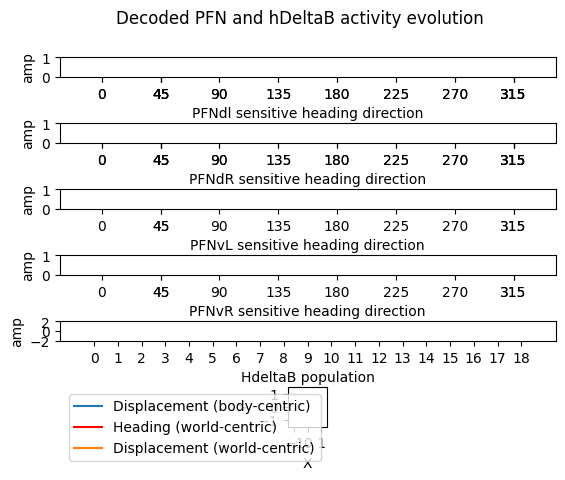

<Figure size 800x600 with 0 Axes>

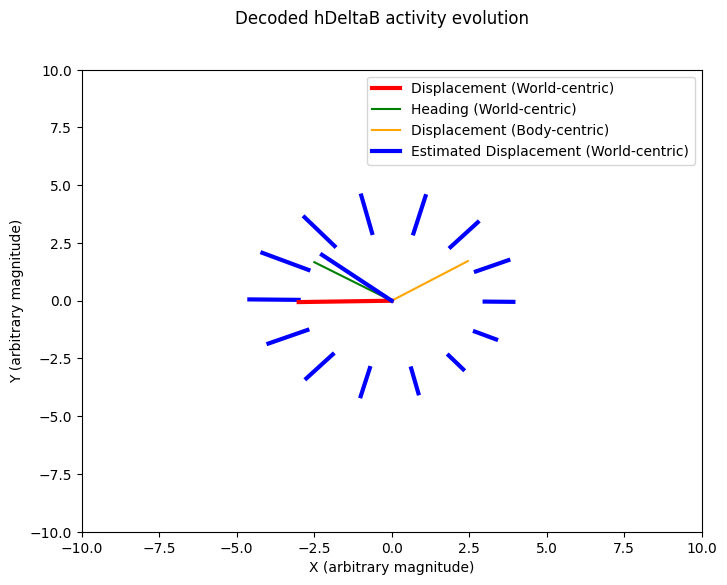

In [12]:
### Initialize the navigator and run on the logged data
from navigator import NeuralNavigationModel
import os

def load_csv_to_array(file_path):
    data = np.loadtxt(file_path, delimiter=",", dtype=int)
    return data
current_directory = os.getcwd()

W_PFNdL_hDb = load_csv_to_array(current_directory + "\connectivity\PFNdL_hDb.csv")
W_PFNdR_hDb = load_csv_to_array(current_directory + "\connectivity\PFNdR_hDb.csv")
W_PFNvL_hDb = load_csv_to_array(current_directory + "\connectivity\PFNvL_hDb.csv")
W_PFNvR_hDb = load_csv_to_array(current_directory + "\connectivity\PFNvR_hDb.csv")

# normalize weight matrices along each row
W_PFNdL_hDb = 6.0*np.divide(W_PFNdL_hDb, np.sum(W_PFNdL_hDb, 1)[:,None])
W_PFNdR_hDb = 6.0*np.divide(W_PFNdR_hDb, np.sum(W_PFNdR_hDb, 1)[:,None])
W_PFNvL_hDb = np.divide(W_PFNvL_hDb, np.sum(W_PFNvL_hDb, 1)[:,None])
W_PFNvR_hDb = np.divide(W_PFNvR_hDb, np.sum(W_PFNvR_hDb, 1)[:,None])

weights = [W_PFNdL_hDb, np.roll(W_PFNdR_hDb,-5), W_PFNvL_hDb, W_PFNvR_hDb] # LR shift in W_PFNdR_hDb

EPGL_PFNDL = load_csv_to_array(current_directory + "\connectivity\EPGL_PFNdL.csv")
EPGR_PFNDR = load_csv_to_array(current_directory + "\connectivity\EPGR_PFNdR.csv")
EPGL_PFNVL = load_csv_to_array(current_directory + "\connectivity\EPGL_PFNvL.csv")
EPGR_PFNVR = load_csv_to_array(current_directory + "\connectivity\EPGR_PFNvR.csv")

epg_pfn_mappings = [EPGL_PFNDL, EPGR_PFNDR, EPGL_PFNVL, EPGR_PFNVR]

preferred_orientations_PFNdL = np.array(
    [
        180, #-180,
        180, #-180,
        225, #-135,
        225, #-135,
        270, #-90,
        270, #-90,
        315, #-45,
        315, #-45,
        315, #-45,
        315, #-45,
        0,
        0,
        45,
        45,
        45,
        45,
        90,
        90,
        135,
        135,
    ]
)*np.pi/180
preferred_orientations_PFNdR = np.flip(np.array(
    [
        180, #-180,
        180, #-180,
        225, #-135,
        225, #-135,
        270, #-90,
        270, #-90,
        315, #-45,
        315, #-45,
        315, #-45,
        315, #-45,
        0,
        0,
        45,
        45,
        45,
        45,
        90,
        90,
        135,
        135,
    ]
))*np.pi/180
preferred_orientations_PFNdR = np.concatenate((np.array([np.pi,np.pi]),preferred_orientations_PFNdR[:-2]))

preferred_orientations_PFNvL = np.array(
    [
        180, #-180,
        225, #-135,
        270, #-90,
        315, #-45,
        315, #-45,
        0,
        45,
        45,
        90,
        135
    ]
)*np.pi/180
preferred_orientations_PFNvR = np.flip(np.array(
    [
        180, #-180,
        225, #-135,
        270, #-90,
        315, #-45,
        315, #-45,
        0,
        45,
        45,
        90,
        135
    ]
))*np.pi/180
preferred_orientations_PFNvR = np.concatenate((np.array([np.pi]),preferred_orientations_PFNvR[:-1]))

# list of one dimensional preferred orientations (in rad in the world frame) for each population [PFNdl, PFNdr, PFNvl, PFNvr]
preferred_orientations = [preferred_orientations_PFNdL, preferred_orientations_PFNdR, preferred_orientations_PFNvL, preferred_orientations_PFNvR]

preferred_directions = [
    np.array([np.cos(31*np.pi/180), np.sin(31*np.pi/180)]),  # PFNdl
    np.array([np.cos(-31*np.pi/180), np.sin(-31*np.pi/180)]),  # PFNDr
    np.array([np.cos(137*np.pi/180), np.sin(137*np.pi/180)]),  # PFNvl
    np.array([np.cos(-137*np.pi/180), np.sin(-137*np.pi/180)]),  # PFNvr
]  # list of preferred directions (2D unit vectors in the body frame) for each population [PFNdl, PFNdr, PFNvl, PFNvr]

hDeltaB_remapping = [
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
    ]

test_model = NeuralNavigationModel(
    weights=weights,
    preferred_directions=preferred_directions,
    preferred_orientations=preferred_orientations,
    hDeltaB_remapping=hDeltaB_remapping,
    epg_pfn_mappings=epg_pfn_mappings,
    realistic_mode=True
)

test_model.init_PB_activities_recording()
test_model.init_PFN_activities_recording([0, 1, 2, 3])
test_model.init_hDeltaB_activities_recording()

for (theta, displacement) in zip(orientation_angle, body_displacement):
    test_model.forward(displacement, theta)
    test_model.decode()
    test_model.log_state()
    
animation_interval = 1000/sample_rate/render_playspeed

# NOTE: uncomment to save different animations and plots
# test_model.show_PB_animations(interval=animation_interval, path="./outputs/PB_animations.mp4")
# test_model.show_PFN_animations(interval=animation_interval, path="./outputs/PFN_animation.mp4")
test_model.show_hDeltaB_animation2(interval=animation_interval, path="./outputs/hDeltaB_animation.mp4")
# test_model.show_angle_evolutions()
